# Importe

In [ ]:
!pip install sdtfile
# !pip install shutil

In [120]:
import shutil

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for reading and downloading files
from urllib import request
import codecs
import requests
from google.colab import files

# reading sdt files
import sdtfile
from sdtfile.sdtfile import SdtFile

# writing folders and files
import os

In [3]:
# help(sdtfile)

# Funktionen

In [122]:
class math_func():
  def af(N0,t,t0,tau):
    N = N0 * np.exp(-(t-t0)/tau)
    return N

  def snr(Nmax, Nrausch):
    snr = (Nmax-Nrausch)/Nrausch
    return snr

  def anisotropie(I_par,I_ortho):
    """
      I_par:      parallele Intensität
      I_ortho:    orthogonale Intensität
    """
    r = (I_par+I_ortho)/(I_par+2*I_ortho)
    return r



class fpr():
  def creating_folder(fn='New-Folder'):
    for i in range(1, 30):
      path = f'/content/{fn}_{i}'
      if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)
        return path

  def download_asc(self,url_list, name_list, foldername):
    if len(url_list) == len(name_list):
      new_folder_path = self.creating_folder(foldername)
      if new_folder_path:
        print(f"New folder created at: {new_folder_path}")
      else:
        print(f"Error creating folder for fn in the creating_folder function. Maximum limit reached.")
    else:
      print("Error: The lists don't have the same length. Change it")

  def download_csv(link,filename,ind=0,h=0):
    !wget {link}
    df = pd.read_csv(f'/content/{filename}',index_col=ind,header=0)
    return df

  def download_file(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded to {save_path}")

  def get_excel_sheet_info(file_path):
    xl = pd.ExcelFile(file_path)
    sheet_count = len(xl.sheet_names)
    sheet_names = xl.sheet_names
    return sheet_count, sheet_names

  def sheet_transform(filename,list_of_sheets):
    lst_of_df = []
    for i in range(len(list_of_sheets)):
      df = pd.read_excel(filename,list_of_sheets[i])
      df = df.drop(0)
      df = df.T
      df.index = range(len(df))
      df.columns = df.iloc[0]
      df = df.drop(0)
      df.index = range(len(df))
      lst_of_df.append(df)
    return lst_of_df

  def df_into_csv_list(list_of_df,folder_path,name_of_csv):
    """
    Needed Packages:        os, google.colab.files
    Description:            This function is for a list of
                            data frames
    """
    # needs the packages os and google.colab.files
    if len(list_of_df) == len(name_of_csv):
      for i in range(len(list_of_df)):
        list_of_df[i].to_csv(os.path.join(folder_path,f"{name_of_csv[i]}.csv"),
                             index=False,
                             encoding='utf-8-sig')
        files.download(f'{folder_path}/{name_of_csv[i]}.csv')
    else:
      print('Both lists have not the same length!')

  def df_into_csv(df,path,name_of_csv):
    df.to_csv(os.path.join(path,f"{name_of_csv}.csv"),
              index=False,encoding='utf-8-sig')

  def list_of_df_from_folder(folder_path):
    """
    Needed Packges: os, pandas as pd
    """
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in csv_files:
      file_path = os.path.join(folder_path,file)
      df = pd.read_csv(file_path)
      df_list.append(df)
    return df_list

  def asc_files(folder_path):
    """
    Needed Packages: os, numpy as np
    """

    asc_files = [f for f in os.listdir(folder_path) if f.endswith('.asc')]
    return asc_files

  def asc_to_array(folder_path):
    # using files
    asc_files = fpr.asc_files(folder_path)

    dt_lists = []
    for i in range(len(asc_files)):
      data = []
      file_path = os.path.join(folder_path,asc_files[i])
      with open(file_path,'r') as f:
        for line in f:
          try:
            # attempt to convert the line to floats
            values = [float(val) for val in line.split()]
            data.append(values)
          except ValueError:
            continue

      dt_lists.append(data)

    return dt_lists

  def list_of_filenames(folder_path):
    """
    Packages: os
    Function to get the filenames without file ending
    """
    all_files = os.listdir(folder_path)
    file_names = [os.path.splitext(file)[0] for file in all_files]
    return file_names

  def sdt_cfd_sw(folder_path):
    """
    Packages: os, sdtfile.sdtfile.SdtFile
    """
    sdt_files = [f for f in os.listdir(folder_path) if f.endswith('.sdt')]

    dfs = []
    file_names = []
    for file in sdt_files:
      # getting file names
      name = os.path.splitext(file)[0]
      file_names.append(name)
      # getting data
      fp = os.path.join(folder_path,file)
      sdt = SdtFile(fp)
      data = sdt.data[0][0]
      dfs.append(data)

    return dfs, file_names

  def data_frame(list_of_arrays,col_names,path,file_name):
    """
    Creating from a list of arrays a data frame.

    Each Array must have a length of 1024 elements.

    List of arrays:       list_of_arrays
    Column names:         col_names
    Folder path:          path
    CSV file name:        file name
    """
    # Creating Data Frame
    time = np.linspace(0,25,1024)
    df = pd.DataFrame(list_of_arrays).T
    df.columns = col_names
    df['Time'] = time

    # Creating CSV File
    fpr.df_into_csv(df,path,file_name)

    # return data frame
    return df

  def plotting_spc(df,col_names,plot_name='plot',label='',save=False):
    """
    Packages: matplotlib.pyplot as plt
    """
    # plotting
    x = df['Time']
    for i in col_names:
      y = df[i]
      plt.plot(x,y,label=label+f' {i}')
    plt.xlabel('Time [s]')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.legend(loc='center right',bbox_to_anchor=(1.25,.5))

    # saving
    if save == False:
      pass
    else:
      plt.savefig(f'{plot_name}.png',dpi=600,transparent=True,bbox_inches = 'tight')

    # showing
    plt.show()

  def sdt_generall(path):
    sdt_files = [f for f in os.listdir(path) if f.endswith('.sdt')]
    fp = os.path.join(path,sdt_files[0])
    sdt = SdtFile(fp)
    data = sdt.data
    dim = len(data)

    file_names = []
    dfs = []
    for i in range(dim):
      nl = []
      dfs.append(nl)

    for file in sdt_files:
      # getting file names
      name = os.path.splitext(file)[0]
      file_names.append(name)
      # getting data
      fp = os.path.join(path,file)
      sdt = SdtFile(fp)
      data = sdt.data
      for i in range(len(data)):
        dfs[i].append(data[i][0])

    return dfs, file_names

  def new_folder_for_files(list_of_files,new_folder_path):
    """
    Packages: shutil, os
    """
    # creating folder:
    os.makedirs(new_folder_path,exist_ok=True)

    # putting files in new folder
    s_f = '/content'
    for file in list_of_files:
      s_p = os.path.join(s_f,file)
      d_p = os.path.join(new_folder_path,file)
      shutil.move(s_p,d_p)


# Data

Spc daten excel datei manuel hochladen

In [5]:
time = np.linspace(0,25,1024)

## Excel Sheets

### xlsx file

In [7]:
# excel_df = fpr.get_excel_sheet_info('SPC_Daten.xlsx')
# excel_df

In [ ]:
# sheets = fpr.sheet_transform('/content/Excel/SPC_Daten.xlsx',excel_df[1])
# print(len(sheets))

In [ ]:
# sheets[3]

In [ ]:
# path = '/content/Excel'
# for i in range(len(sheets)):
#   fpr.df_into_csv(sheets[i],path,excel_df[1][i])

### Daten von GitHub
- Daten sind identisch mit den daten aus dem Kapitel "aus xlsx datei"

In [ ]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Sheets.zip
!unzip Sheets.zip

In [11]:
snr_cfd_sheet = pd.read_csv('1 SNR CFD.csv')
pmt_sheet = pd.read_csv('2 PMT.csv')
laser_int_800_sheet  = pd.read_csv('2.2 Laserint.csv')
pile_up_sheet = pd.read_csv('3 PileUp.csv')
Reab_sheet = pd.read_csv('4 Reabsorp.csv')
Pheo_sheet = pd.read_csv('5 Pheo in EthWass.csv')
miz_sheet = pd.read_csv('6 EinbettMiz.csv')

In [12]:
sheets = [snr_cfd_sheet,pmt_sheet,
          laser_int_800_sheet, pile_up_sheet,
          Reab_sheet, Pheo_sheet,
          miz_sheet]

## cfd Schwellenwerte

### ascii files

In [13]:
# path1 = '/content/Row_Data/CFD'
# path2 = '/content/Row_Data'
# test = fpr.asc_to_array(path2)
# cfd_asc = fpr.asc_to_array(path1)

In [14]:
# len(cfd_asc[0][1])

In [15]:
# pd_series = []
# for i in range(len(cfd_asc)):
#   arr = []
#   for j in range(len(cfd_asc[i])):
#     if len(cfd_asc[i][j]) == 0:
#       continue
#     else:
#       x = cfd_asc[i][j][0]
#       arr.append(x)
#   # print(len(arr))
#   pd_series.append(arr)

# pd_series = np.array(pd_series).T

In [16]:
# names = [10,15,20,25,30,35,40,45,50,5]
# cfd_df = pd.DataFrame(pd_series,columns=names)

In [17]:
# cfd_df[10].plot(logy=True)
# cfd_df[5].plot(logy=True)
# # cfd_df[50].plot(logy=True)
# cfd_df[30].plot(logy=True)


In [18]:
# df = [cfd_df]
# name = ['CFD_Schwellenwerte']
# fpr.df_into_csv(df,'/content',name)

### sdt files

In [19]:
# path = '/content/cfd_sw'
# cfd_sw_data = fpr.sdt_cfd_sw(path)

In [20]:
# cfd_sw_names = cfd_sw_data[1]
# cfd_data = cfd_sw_data[0]

In [21]:
# milli_volt = [10,45,20,5,50,35,15,25,30,40]
# cfd_sw_names

In [22]:
# df_cfd_sw = pd.DataFrame(cfd_data).T
# df_cfd_sw.columns = milli_volt
# df_cfd_sw['Time'] = time

In [23]:
# df_cfd_sw.head()

In [24]:
# path = '/content'
# fpr.df_into_csv(df_cfd_sw,path,"CFD-Schwellenwerte")

In [25]:
# x = df_cfd_sw['Time']
# for i in range(len(milli_volt)):
#   y = df_cfd_sw[milli_volt[i]]
#   plt.plot(x,y,label=f'{milli_volt[i]} mV')
#   plt.yscale('log')
# plt.legend(loc='center right',bbox_to_anchor=(1.25,.5))
# plt.xlabel('Time [s]')
# plt.ylabel('Counts')
# plt.savefig('CFD-Schwellenwerte.png',dpi=600,transparent=True,bbox_inches = 'tight')

### github

In [26]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/CFD-Schwellenwerte.zip

--2023-09-18 12:34:59--  https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/CFD-Schwellenwerte.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/CFD-Schwellenwerte.zip [following]
--2023-09-18 12:34:59--  https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/CFD-Schwellenwerte.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20236 (20K) [application/zip]
Saving to: ‘CFD-Schwellenwerte.zip’

CFD-Schwellenwerte. 100%[===================>]  19.76K  --.-

In [27]:
!unzip CFD-Schwellenwerte.zip

Archive:  CFD-Schwellenwerte.zip
  inflating: CFD-Schwellenwerte.csv  


In [28]:
df_cfd_sw = pd.read_csv('CFD-Schwellenwerte.csv')

In [29]:
df_cfd_sw.head()

,10,45,20,5,50,35,15,25,30,40,Time
0,82,5,25,3600,2,13,26,21,21,10,0.000000
1,95,4,23,3652,2,18,20,31,14,4,0.024438
2,103,7,29,3614,3,13,24,27,20,7,0.048876
3,108,7,25,3542,3,7,31,24,13,7,0.073314
4,104,8,30,3511,4,11,28,29,15,6,0.097752


## PMT

### sdt Dateien

In [30]:
# path = '/content/PMT'
# PMT = fpr.sdt_cfd_sw(path)

In [31]:
# PMT_data = PMT[0]
# PMT_f_names = PMT[1]
# D_volt = [850,750,1000,700,900,800]
# PMT_f_names

In [32]:
# df_pmt = pd.DataFrame(PMT_data).T
# df_pmt.columns = D_volt
# df_pmt['Time'] = time
# df_pmt

In [33]:
# Downlaoding csv for github
# path = '/content'
# fpr.df_into_csv(df_pmt,path,"PMT-D-Spannung")

In [34]:
# colors_6 = ['red','black','blue']

In [35]:
# x = df_pmt['Time']
# for i in [0,1,2]:
#   y = df_pmt[D_volt[i]]
#   plt.plot(x,y,label=f'{D_volt[i]} V',color=colors_6[i])
# plt.xlabel('Time [s]')
# plt.ylabel('Counts')
# plt.yscale('log')
# plt.legend(loc='center right',bbox_to_anchor=(1.25,.5))
# plt.savefig('PMT-D-Volt-Teil-1.png',dpi=600,transparent=True,bbox_inches = 'tight')

In [36]:
# x = df_pmt['Time']
# for i in [0,1,2]:
#   y = df_pmt[D_volt[i+3]]
#   plt.plot(x,y,label=f'{D_volt[i+3]} V',color=colors_6[i])
# plt.xlabel('Time [s]')
# plt.ylabel('Counts')
# plt.yscale('log')
# plt.legend(loc='center right',bbox_to_anchor=(1.25,.5))
# plt.savefig('PMT-D-Volt-Teil-2.png',dpi=600,transparent=True,bbox_inches = 'tight')

### Github

In [37]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/PMT-D-Spannung.zip
!unzip PMT-D-Spannung.zip

--2023-09-18 12:35:05--  https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/PMT-D-Spannung.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/PMT-D-Spannung.zip [following]
--2023-09-18 12:35:06--  https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/PMT-D-Spannung.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11229 (11K) [application/zip]
Saving to: ‘PMT-D-Spannung.zip’

PMT-D-Spannung.zip  100%[===================>]  10.97K  --.-KB/s    in 0.001

In [38]:
df_pmt = pd.read_csv('PMT-D-Spannung.csv')
df_pmt.head()

,850,750,1000,700,900,800,Time
0,8,2,2,0,3,5,0.000000
1,8,1,3,0,6,6,0.024438
2,6,2,2,0,6,7,0.048876
3,3,1,2,0,8,6,0.073314
4,5,3,4,0,6,8,0.097752


## Laserintensität

### 800V Detektorspannung

#### SDT

In [39]:
# uploaded = files.upload()

In [40]:
# path_800 = '/content/LI/800V'
# data_800, names_800 = fpr.sdt_cfd_sw(path_800)

In [41]:
# data_800

In [42]:
# position = [3,7,0,45,4]
# names_800

In [43]:
# df_800 = fpr.data_frame(data_800,position,path_800,'LI_800V')

# df_800.head()

In [44]:
# help(fpr.plotting_spc)

In [45]:
# fpr.plotting_spc(df_800,position,plot_name='LI-800V',label='Position',save=True)

#### Github

In [46]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/LI_800V.zip
!unzip LI_800V.zip

--2023-09-18 12:35:26--  https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/LI_800V.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/LI_800V.zip [following]
--2023-09-18 12:35:26--  https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/LI_800V.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11440 (11K) [application/zip]
Saving to: ‘LI_800V.zip’

LI_800V.zip         100%[===================>]  11.17K  --.-KB/s    in 0.002s  

2023-09-18 12:35:26 (5.

In [47]:
LI_800V = pd.read_csv('LI_800V.csv')
LI_800V.head()

,3,7,0,45,4,Time
0,14,6,6,7,5,0.000000
1,6,3,6,4,6,0.024438
2,6,6,6,9,5,0.048876
3,7,8,2,5,2,0.073314
4,6,10,6,7,2,0.097752


### 850V Detektorspannung

#### SDT Files

In [48]:
# uploaded = files.upload()
# path_850 = '/content/LI/850V'
# data_850, names_850 = fpr.sdt_cfd_sw(path_850)

In [49]:
# position_850 = [7,4,1]
# names_850

In [50]:
# df_850 = fpr.data_frame(data_850,position_850,path_850,'LI_850V')

# df_850.head()

In [51]:
# fpr.plotting_spc(df_850,position_850,plot_name='LI-850V',label='Position',save=True)

#### Github

In [52]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/LI_850V.zip
!unzip LI_850V.zip

--2023-09-18 12:35:27--  https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/LI_850V.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/LI_850V.zip [following]
--2023-09-18 12:35:27--  https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/LI_850V.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9349 (9.1K) [application/zip]
Saving to: ‘LI_850V.zip’

LI_850V.zip         100%[===================>]   9.13K  --.-KB/s    in 0.001s  

2023-09-18 12:35:28 (9.

In [53]:
LI_850V = pd.read_csv('LI_850V.csv')
LI_850V.head()

,7,4,1,Time
0,11,9,5,0.000000
1,7,6,9,0.024438
2,7,6,10,0.048876
3,10,7,7,0.073314
4,8,3,8,0.097752


## Apparatefunktion

### SDT

In [54]:
# uploaded = files.upload()
# path_AF = '/content/AF'

In [55]:
# arr_AF, AF_name = fpr.sdt_generall(path_AF)

In [56]:
# arr_AF

In [57]:
# arr_AF = arr_AF[0]
# print(arr_AF)
# print(AF_name)

In [58]:
# position = [45]
# df_AF = fpr.data_frame(arr_AF,position,path_AF,'AF')

In [59]:
# df_AF.head()

In [60]:
# fpr.plotting_spc(df_AF,position,plot_name='Apparate-Funktion',label='Position',save=True)

### Github

In [61]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/AF.zip
!unzip AF.zip

--2023-09-18 12:35:50--  https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/AF.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/AF.zip [following]
--2023-09-18 12:35:50--  https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/AF.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6355 (6.2K) [application/zip]
Saving to: ‘AF.zip’

AF.zip              100%[===================>]   6.21K  --.-KB/s    in 0s      

2023-09-18 12:35:51 (67.7 MB/s) - ‘AF.zip’ 

In [62]:
Apparate_Funk = pd.read_csv('AF.csv')
Apparate_Funk.head()

,45,Time
0,7,0.000000
1,4,0.024438
2,9,0.048876
3,5,0.073314
4,7,0.097752


## Pile-Up Effekt

### SDT

In [63]:
# uploaded = files.upload()
# path_puf = "/content/PUE"

In [64]:
# puf_arr, pu_name = fpr.sdt_generall(path_puf)

In [65]:
# puf_arr_1 = puf_arr[0]
# puf_arr_2 = puf_arr[1]

# lst1 = []
# lst2 = []

# for i in range(len(puf_arr_1)):
#   lst1.append(puf_arr_1[i])
#   lst2.append(puf_arr_2[i])

# puf_arr_1 = lst1
# puf_arr_2 = lst2

In [66]:
# for i in range(len(pu_name)):
#   pu_name[i] = int(pu_name[i])

In [67]:
# df_pu_1 = fpr.data_frame(puf_arr_1,pu_name,path_puf,'PUF1')
# print(df_pu_1.head())
# df_pu_2 = fpr.data_frame(puf_arr_2,pu_name,path_puf,'PUF2')
# print(df_pu_2.head())

In [68]:
# df_pu = df_pu_2
# df_pu['AF'] = df_pu_1[50]

In [69]:
# df_pu.head()

In [70]:
# df_pu.to_csv('Pile-Up-Effekt.csv')

### ASCII

In [71]:
# # uploaded = files.upload()
# path_puf = "/content/PUE"

In [73]:
# asc_names = fpr.asc_files(path_puf)
# arrays = fpr.asc_to_array(path_puf)

In [74]:
# asc_names

In [75]:
# for i in range(len(arrays)):
#   print(len(arrays[i]))

In [77]:
# for i in range(len(arrays)):
#   print(arrays[i][2000])

### Github

In [78]:
# Pile-Up Effect
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Pile-Up-Effekt.zip
!unzip Pile-Up-Effekt.zip

--2023-09-18 12:36:32--  https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Pile-Up-Effekt.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/Pile-Up-Effekt.zip [following]
--2023-09-18 12:36:33--  https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/Pile-Up-Effekt.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23995 (23K) [application/zip]
Saving to: ‘Pile-Up-Effekt.zip’

Pile-Up-Effekt.zip  100%[===================>]  23.43K  --.-KB/s    in 0.007

In [79]:
df_puf = pd.read_csv('Pile-Up-Effekt.csv')
df_puf.head()

,Unnamed: 0,50,47,45,53,49,52,46,51,48,Time,AF
0,0,108,22,17,47,75,9,18,118,48,0.000000,3
1,1,111,27,11,37,88,12,18,120,52,0.024438,8
2,2,97,29,11,42,88,9,16,116,45,0.048876,5
3,3,113,42,10,45,70,9,18,129,61,0.073314,9
4,4,107,40,13,31,77,3,22,108,47,0.097752,5


In [80]:
df_puf = df_puf.drop('Unnamed: 0',axis=1)
df_puf.head()

,50,47,45,53,49,52,46,51,48,Time,AF
0,108,22,17,47,75,9,18,118,48,0.000000,3
1,111,27,11,37,88,12,18,120,52,0.024438,8
2,97,29,11,42,88,9,16,116,45,0.048876,5
3,113,42,10,45,70,9,18,129,61,0.073314,9
4,107,40,13,31,77,3,22,108,47,0.097752,5


In [81]:
names = ['50','47','45','53','49','52','46','51','48']

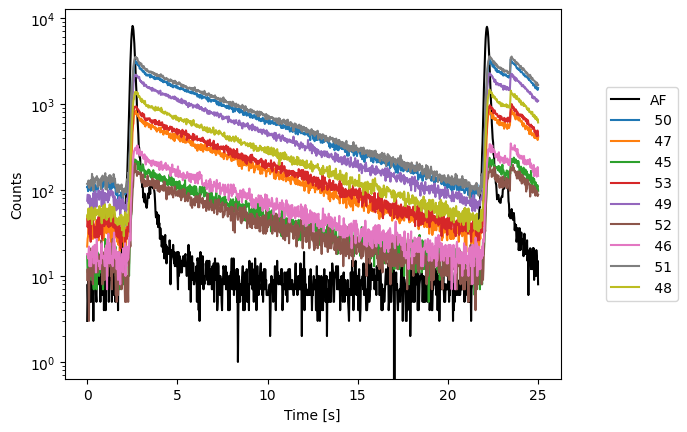

In [82]:
plt.plot(df_puf['Time'],df_puf['AF'],color='k',label='AF')
fpr.plotting_spc(df_puf,names,plot_name='Pile-Up-Effekt',label='',save=False)

## Reabsorption

#### SDT

In [86]:
# uploaded = files.upload()
# path_ra = '/content/RA'

In [87]:
# ra_arr, ra_name = fpr.sdt_generall(path_ra)

In [88]:
# ra_name

In [89]:
# ra_arr1 = ra_arr[0]
# ra_arr2 = ra_arr[1]

In [90]:
# df_ra_1 = fpr.data_frame(ra_arr1,ra_name,path_ra,'Reabsorption_1')
# df_ra_2 = fpr.data_frame(ra_arr2,ra_name,path_ra,'Reabsorption_2')

In [91]:
# df_ra_1.head()

In [92]:
# df_ra_2.head()

In [93]:
# df_ra = df_ra_2
# df_ra['AF'] = df_ra_1['52']
# df_ra.head()

In [94]:
# df_ra.to_csv('Reabsorption.csv')

In [95]:
# plt.plot(df_ra['Time'],df_ra['AF'],color='k',label='AF')
# fpr.plotting_spc(df_ra,ra_name,plot_name='Reabsorption',label='MV',save=True)

### Github

In [ ]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Reabsorption.zip
!unzip Reabsorption.zip

In [97]:
Reab = pd.read_csv('Reabsorption.csv')

## Phe in Ethanol-Wasser-Gemisch

#### SDT

In [98]:
# uploaded = files.upload()
# path_pheo = '/content/Phe'

In [99]:
# pheo_arr, pheo_name = fpr.sdt_generall(path_pheo)
# print(pheo_name)
# pheo_arr

In [100]:
# pheo_arr1 = pheo_arr[0]
# pheo_arr2 = pheo_arr[1]

In [101]:
# df_pheo_1 = fpr.data_frame(pheo_arr1,pheo_name,path_pheo,'Pheo_EWG_1')
# df_pheo_2 = fpr.data_frame(pheo_arr2,pheo_name,path_pheo,'Pheo_EWG_2')

In [102]:
# print(df_pheo_1.head())
# print(df_pheo_2.head())

In [103]:
# df_pheo = df_pheo_2
# df_pheo['AF'] = df_pheo_1['pe-1-3-1']
# df_pheo.head()

In [104]:
# df_pheo.to_csv('Pheo_EWG.csv')

In [105]:
# plt.plot(df_pheo['Time'],df_pheo['AF'],color='k',label='AF')
# fpr.plotting_spc(df_pheo,pheo_name,plot_name='Pheo_EWG_Plot',label='MV',save=True)

### Github

In [ ]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Pheo_EWG.zip
!unzip Pheo_EWG.zip

In [112]:
pheo_ewg = pd.read_csv('Pheo_EWG.csv')
pheo_ewg = pheo_ewg.drop('Unnamed: 0',axis=1)
pheo_ewg.head()

,pe-1-4-0,pe-1-2-2,pe-1-1-3,pe-1-3-1,pe-1-0-4,Time,AF
0,3,15,20,2,12,0.000000,3
1,7,16,13,10,11,0.024438,8
2,9,16,15,10,11,0.048876,5
3,5,10,12,9,15,0.073314,9
4,7,22,16,11,20,0.097752,5


## Triton

### SDT from Github

In [ ]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/6_Triton/1-4-0_mit%20triton.sdt
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/6_Triton/pe-1-0-4_0Grad.sdt

In [123]:
# old path
path_triton_140 = '1-4-0_mit triton.sdt'
path_triton_104_0Grad = 'pe-1-0-4_0Grad.sdt'
lst_path = [path_triton_140,path_triton_104_0Grad]

# new path:
triton_path = '/content/triton'

# new folder
fpr.new_folder_for_files(lst_path, triton_path)

In [127]:
triton_data,triton_names = fpr.sdt_generall(triton_path)

In [141]:
df_triton_1 = fpr.data_frame(triton_data[0],triton_names,triton_path,'Triton_1')
df_triton_2 = fpr.data_frame(triton_data[1],triton_names,triton_path,'Triton_2')

In [142]:
df_triton_1.head()

,pe-1-0-4_0Grad,1-4-0_mit triton,Time
0,3,3,0.000000
1,8,8,0.024438
2,5,5,0.048876
3,9,9,0.073314
4,5,5,0.097752


In [143]:
df_triton_2.head()

,pe-1-0-4_0Grad,1-4-0_mit triton,Time
0,12,14,0.000000
1,11,11,0.024438
2,11,15,0.048876
3,15,18,0.073314
4,20,18,0.097752


In [146]:
# print(df_triton_2.head())
df_triton = df_triton_2
df_triton['AF'] = df_triton_1['1-4-0_mit triton']
# print(df_triton_2.head())
df_triton.to_csv('Triton.csv')
df_triton.head()

,pe-1-0-4_0Grad,1-4-0_mit triton,Time,AF
0,12,14,0.000000,3
1,11,11,0.024438,8
2,11,15,0.048876,5
3,15,18,0.073314,9
4,20,18,0.097752,5


### ASCII files

### Github

## Anisotropie

### SDT

In [ ]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/7_Anisotropie/1-4-0_mit%20triton_0Grad.sdt
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/7_Anisotropie/1-4-0_mit%20triton_90grad.sdt
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/7_Anisotropie/pe-1-0-4_0Grad.sdt
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/7_Anisotropie/pe-1-0-4_90grad.sdt

In [154]:
# old path
pe_104_90 = 'pe-1-0-4_90grad.sdt'
pe_104_0 = 'pe-1-0-4_0Grad.sdt'
pe_140_90 = '1-4-0_mit triton_90grad.sdt'
pe_140_0 = '1-4-0_mit triton_0Grad.sdt'
lst_path = [pe_104_90, pe_104_0, pe_140_0, pe_140_90]

# new path:
anisotropie_path = '/content/Anisotropie'

# new folder
fpr.new_folder_for_files(lst_path, anisotropie_path)

In [155]:
anis_data, anis_names = fpr.sdt_generall(anisotropie_path)

In [156]:
anis_data

[[array([ 3,  8,  5, ..., 10, 15,  8], dtype=uint16),
  array([ 3,  8,  5, ..., 10, 15,  8], dtype=uint16),
  array([ 3,  8,  5, ..., 10, 15,  8], dtype=uint16),
  array([ 3,  8,  5, ..., 10, 15,  8], dtype=uint16)],
 [array([ 12,  11,  11, ..., 152, 154, 141], dtype=uint16),
  array([ 13,  17,  19, ..., 145, 139, 134], dtype=uint16),
  array([ 12,  14,   6, ..., 100,  83,  89], dtype=uint16),
  array([ 14,  11,  15, ..., 128, 139, 126], dtype=uint16)]]

In [159]:
df_anis_1 = fpr.data_frame(anis_data[0],anis_names,anisotropie_path,'Anisotropie_1')
df_anis_2 = fpr.data_frame(anis_data[1],anis_names,anisotropie_path,'Anisotropie_2')

In [160]:
df_anis_1.head()

,pe-1-0-4_0Grad,pe-1-0-4_90grad,1-4-0_mit triton_90grad,1-4-0_mit triton_0Grad,Time
0,3,3,3,3,0.000000
1,8,8,8,8,0.024438
2,5,5,5,5,0.048876
3,9,9,9,9,0.073314
4,5,5,5,5,0.097752


In [161]:
df_Anisotropie = df_anis_2
df_Anisotropie['AF'] = df_anis_1['1-4-0_mit triton_0Grad']
df_Anisotropie.to_csv('Anisotropie.csv')
df_Anisotropie.head()

,pe-1-0-4_0Grad,pe-1-0-4_90grad,1-4-0_mit triton_90grad,1-4-0_mit triton_0Grad,Time,AF
0,12,13,12,14,0.000000,3
1,11,17,14,11,0.024438,8
2,11,19,6,15,0.048876,5
3,15,19,17,18,0.073314,9
4,20,16,10,18,0.097752,5


### Github

In [163]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Anisotropie.zip
!unzip Anisotropie.zip

--2023-09-18 13:49:57--  https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/TCSPC/Data/CSV-Files/Anisotropie.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/Anisotropie.zip [following]
--2023-09-18 13:49:58--  https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/TCSPC/Data/CSV-Files/Anisotropie.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14100 (14K) [application/zip]
Saving to: ‘Anisotropie.zip.1’

Anisotropie.zip.1   100%[===================>]  13.77K  --.-KB/s    in 0.002s  

2023-